# core

> Fill in a module description here

In [1]:
# | default_exp vae


In [2]:
# | hide
from nbdev.showdoc import *


In [3]:
# | export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
from scipy import signal
import os
import math


In [4]:
num_workers = os.cpu_count()
num_workers


4

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [5]:
data = np.load("../sample_data/nyc_taxi.npz")
for k in data.keys():
    print(k)

t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


In [6]:
data["t_unit"]  # 1 hour is 2 steps, 24hrs is 48 steps


array('30 min', dtype='<U6')

In [7]:
data["training"].shape

(5500,)

In [8]:
df = pd.DataFrame(data["training"], index=data["t_train"], columns=["value"])
df

,value
1,-0.647416
2,-1.048144
3,-1.330880
4,-1.560078
5,-1.683378
...,...
5496,0.650634
5497,0.769805
5498,0.614499
5499,0.474090


In [9]:
window_size = 48  # so that one window is one day

data = [
    {
        "subset": get_window(
            df.values,
            window_size=window_size,
            end_step=end_step,
            indices=list(df.index),
            return_indices=False,
        ),
        "end_step": end_step,
        "start_step": end_step - window_size,
    }
    for end_step in range(window_size, len(df))
]

In [10]:
# Number of datapoints
len(df) - window_size

5452

Preseve 10% of the dataset from this for validation set.

In [11]:
val_data_idxs = np.random.choice(
    range(len(data)), size=int(0.1 * len(data)), replace=False
)
trn_data_idxs = [idx for idx in range(len(data)) if idx not in val_data_idxs]
len(val_data_idxs), len(trn_data_idxs)

(545, 4907)

In [12]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

In [13]:
val_data = [data[idx] for idx in val_data_idxs]
trn_data = [data[idx] for idx in trn_data_idxs]

Calculate stats over training data.

In [14]:
trn_data[0]["subset"].shape

(48, 1)

In [15]:
n_features = trn_data[0]["subset"].shape[1]  # - 1
n_features


1

In [16]:
means = np.zeros((len(trn_data), n_features))  # ((len(trn_data), 4))
stds = np.zeros((len(trn_data), n_features))  # ((len(trn_data), 4))
slice_from = n_features - 1
"""
for i, _trn_data in enumerate(trn_data):
    means[i] = (np.mean(_trn_data["subset"][:, slice_from:], axis=0)).astype(np.float32)
    stds[i] = (np.var(_trn_data["subset"][:, slice_from:], axis=0) ** 0.5).astype(
        np.float32
    )
"""
means = means.mean(0)
stds = stds.mean(0)

means, stds


(array([0.]), array([0.]))

only first feature is numeric, so remove mean and std from the rest.

In [17]:
means[slice_from:] = 0
stds[slice_from:] = 1
means, stds


(array([0.]), array([1.]))

In [18]:
class TSDataset(Dataset):
    def __init__(self, data, mean, std):
        self.data = data
        self.mean = mean
        self.std = std

    def __getitem__(self, idx):
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        # ignore the timestamp column
        x = self.data[idx]["subset"][:, slice_from:]  # 1024, 4
        normed_X = ((x - self.mean) / (self.std + 1e-8)).astype(np.float32)
        return torch.as_tensor(normed_X)

    def __len__(self):
        return len(self.data)

In [19]:
dset_trn = TSDataset(trn_data, mean=means, std=stds)
dset_val = TSDataset(
    val_data, mean=means, std=stds
)  # use same stats from training data


In [20]:
dset_trn[0].shape


torch.Size([48, 1])

In [21]:
batch_size = 32

In [22]:
dl_trn = DataLoader(
    dataset=dset_trn,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=num_workers,
)
dl_val = DataLoader(
    dataset=dset_val,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=num_workers,
)

In [23]:
xs = next(iter(dl_trn))
xs.shape

torch.Size([32, 48, 1])

In [24]:
xs.shape

torch.Size([32, 48, 1])

In [25]:
num_hidden_units = 512
kernel_size = (3, 1)
stride = (2, 1)
xs_c1 = nn.Conv2d(
    in_channels=1,
    out_channels=num_hidden_units // 16,
    kernel_size=kernel_size,
    stride=stride,
)(xs.unsqueeze(1))
xs_c2 = nn.Conv2d(
    in_channels=num_hidden_units // 16,
    out_channels=num_hidden_units // 8,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c1)
xs_c3 = nn.Conv2d(
    in_channels=num_hidden_units // 8,
    out_channels=num_hidden_units // 4,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c2)
xs_c4 = nn.Conv2d(
    in_channels=num_hidden_units // 4,
    out_channels=num_hidden_units // 1,
    kernel_size=(4, 1),
    stride=stride,
)(xs_c3)
xs_c1.shape, xs_c2.shape, xs_c3.shape, xs_c4.shape


(torch.Size([32, 32, 23, 1]),
 torch.Size([32, 64, 11, 1]),
 torch.Size([32, 128, 5, 1]),
 torch.Size([32, 512, 1, 1]))

In [26]:
xs_c4.mean()


tensor(-0.0030, grad_fn=<MeanBackward0>)

In [27]:
# | export

# encoder
# l_win to 24, the model would consider each 24-hour period as one sequence.
# pad: if your array is [1, 2, 3] and you symmetrically pad it with 1 unit, the result would be [2, 1, 2, 3, 2].
# xavier_initializer()
# conv 1: num_hidden_units / 16
# conv 2: num_hidden_units / 8
# conv 3: num_hidden_units / 4
# conv 4: num_hidden_units / 1, kernel = 4, 1
# padding : same


class Encoder(nn.Module):
    def __init__(
        self,
        latent_dim=20,
        num_hidden_units=512,
        kernel_size=(3, 1),
        stride=(2, 1),
        act=F.mish,
    ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=num_hidden_units // 16,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_hidden_units // 16,
            out_channels=num_hidden_units // 8,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.conv3 = nn.Conv2d(
            in_channels=num_hidden_units // 8,
            out_channels=num_hidden_units // 4,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.conv4 = nn.Conv2d(
            in_channels=num_hidden_units // 4,
            out_channels=num_hidden_units,
            kernel_size=(4, 1),
            stride=stride,
        )
        self.linear = nn.Linear(
            in_features=num_hidden_units, out_features=num_hidden_units, bias=True
        )
        self.linear_mean = nn.Linear(
            in_features=num_hidden_units, out_features=latent_dim, bias=True
        )
        self.linear_var = nn.Linear(
            in_features=num_hidden_units, out_features=latent_dim, bias=True
        )
        self.act = act
        self.init_weights()

    def forward(self, x):
        x = x.unsqueeze(1)  # 100, 1, 48, 1
        x = self.act(self.conv1(x))  # 100, 32, 23, 1
        x = self.act(self.conv2(x))  # 100, 64, 11, 1
        x = self.act(self.conv3(x))  # 100, 128, 5, 1
        x = self.act(self.conv4(x))  # 100, 512, 1, 1
        x = self.flatten(x)  # 100, 512
        x = self.act(self.linear(x))  # 100, 512
        z_mean = self.linear_mean(x)
        z_log_var = self.linear_var(x)
        return z_mean, z_log_var

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)


In [28]:
emb_mean, emb_var = Encoder(latent_dim=20)(xs)
emb_mean.shape, emb_var.shape


(torch.Size([32, 20]), torch.Size([32, 20]))

In [29]:
emb_mean.mean(), emb_var.mean()

(tensor(-0.0007, grad_fn=<MeanBackward0>),
 tensor(0.0010, grad_fn=<MeanBackward0>))

In [30]:
# | export


class StochasticSampler(nn.Module):
    def __init__(self):
        super().__init__()
        self.sampler = torch.distributions.Normal(loc=0, scale=1)

    def forward(self, z_mean, z_log_var):
        # z_mean and z_log_var are mean and log-var estimates of the latent space
        # under the assumption that the latent space is a gaussian normal
        device = z_mean.device
        eps = self.sampler.sample(z_mean.shape).squeeze().to(device)
        # print(eps.shape, z_log_var.shape, z_mean.shape)
        return z_mean + torch.exp(0.5 * z_log_var) * eps

In [31]:
sampler = StochasticSampler()
emb = sampler(emb_mean, emb_var)
emb.shape, emb.requires_grad


(torch.Size([32, 20]), True)

In [32]:
kernel_size = (3, 1)
stride = 1
xs_c1 = nn.Linear(in_features=20, out_features=num_hidden_units, bias=True)(emb)
xs_c1 = xs_c1[:, :, None, None]
xs_c2 = nn.ConvTranspose2d(
    in_channels=num_hidden_units,
    out_channels=num_hidden_units // 4,
    kernel_size=(4, 1),
    stride=stride,
)(xs_c1)
xs_c3 = nn.ConvTranspose2d(
    in_channels=num_hidden_units // 4,
    out_channels=num_hidden_units // 8,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c2)
xs_c4 = nn.ConvTranspose2d(
    in_channels=num_hidden_units // 8,
    out_channels=num_hidden_units // 16,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c3)
xs_c5 = nn.ConvTranspose2d(
    in_channels=num_hidden_units // 16,
    out_channels=num_hidden_units // 32,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c4)
xs_c6 = nn.ConvTranspose2d(
    in_channels=num_hidden_units // 32,
    out_channels=num_hidden_units // 64,
    kernel_size=kernel_size,
    stride=stride,
)(xs_c5)
xs_c6 = nn.Flatten()(xs_c6)
xs_c7 = nn.Linear(in_features=96, out_features=48, bias=True)(xs_c6)
xs_c1.shape, xs_c2.shape, xs_c3.shape, xs_c4.shape, xs_c5.shape, xs_c6.shape, xs_c7.shape

(torch.Size([32, 512, 1, 1]),
 torch.Size([32, 128, 4, 1]),
 torch.Size([32, 64, 6, 1]),
 torch.Size([32, 32, 8, 1]),
 torch.Size([32, 16, 10, 1]),
 torch.Size([32, 96]),
 torch.Size([32, 48]))

In [33]:
# decoder


# l_win to 24, the model would consider each 24-hour period as one sequence.
# pad: if your array is [1, 2, 3] and you symmetrically pad it with 1 unit, the result would be [2, 1, 2, 3, 2].
# xavier_initializer()
# dense 1: num_hidden_units
# reshape: (bs, 1, 1, num_hidden_units)  -> this is tensorflow notation, channel at end so actually (bs, num_hidden_units, 1, 1)

# conv 2: num_hidden_units, kernel = 1
# reshape: (bs, 4, 1, num_hidden_units / 4)

# conv 3: num_hidden_units / 4, kernel = 3, 1, stride = 1
# permute depth to spatial tf
# reshape: (bs, 8, 1, num_hidden_units / 8),

# conv 4: num_hidden_units / 8,  kernel = 3, 1, stride = 1
# permute depth to spatial tf
# reshape: (bs, 16, 1, num_hidden_units / 16)

# conv 5: num_hidden_units / 16, kernel = 3, 1, stride = 1
# permute depth to spatial tf
# reshape: (bs, num_hidden_units /16, 1,  16)

# conv 6: num_channel, kernel = 9, 1, stride = 1
# reshape: (bs, l_win, num_channel)

# | export


class Decoder(nn.Module):
    def __init__(
        self,
        latent_dim=20,
        num_hidden_units=512,
        output_shape=(window_size, 1),
        kernel_size=(3, 1),
        stride=1,
        act=F.mish,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.linear = nn.Linear(
            in_features=latent_dim, out_features=num_hidden_units, bias=True
        )
        self.dconv1 = nn.ConvTranspose2d(
            in_channels=num_hidden_units,
            out_channels=num_hidden_units // 4,
            kernel_size=(4, 1),
            stride=stride,
        )
        self.dconv2 = nn.ConvTranspose2d(
            in_channels=num_hidden_units // 4,
            out_channels=num_hidden_units // 8,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.dconv3 = nn.ConvTranspose2d(
            in_channels=num_hidden_units // 8,
            out_channels=num_hidden_units // 16,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.dconv4 = nn.ConvTranspose2d(
            in_channels=num_hidden_units // 16,
            out_channels=num_hidden_units // 32,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.dconv5 = nn.ConvTranspose2d(
            in_channels=num_hidden_units // 32,
            out_channels=num_hidden_units // 64,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.flatten = nn.Flatten()
        self.linear_out = nn.Linear(
            in_features=96, out_features=math.prod(output_shape), bias=True
        )

        self.act = act

        self.init_weights()

    def forward(self, x):
        x = self.linear(x)
        x = x[:, :, None, None]
        x = self.act(self.dconv1(x))
        x = self.act(self.dconv2(x))
        x = self.act(self.dconv3(x))
        x = self.act(self.dconv4(x))
        x = self.act(self.dconv5(x))
        x = self.flatten(x)
        x = self.act(self.linear_out(x))
        return self.reshape_to_output(x)

    def reshape_to_output(self, x):
        bs = x.shape[0]
        return x.reshape(bs, *self.output_shape)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)


In [34]:
Decoder(output_shape=(window_size, n_features))(emb).shape


torch.Size([32, 48, 1])

In [35]:
xs.shape


torch.Size([32, 48, 1])

In [36]:
# | export
class VAE(nn.Module):
    def __init__(self, latent_dim=20, input_shape=(window_size, 1), act=F.leaky_relu):
        super().__init__()
        self.encoder = Encoder(latent_dim=latent_dim, act=act)
        self.decoder = Decoder(latent_dim=latent_dim, output_shape=input_shape, act=act)
        self.latent_sampler = StochasticSampler()
        self.act = act

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.latent_sampler(z_mean, z_log_var)
        out = self.decoder(z)
        # loss to enforce all possible values are sampled from latent space
        # should be of the size of the batch
        loss_kl = -0.5 * torch.sum(
            1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=-1
        )
        return out, loss_kl

In [37]:
xs_pred, loss_kl = VAE(latent_dim=128, input_shape=(window_size, n_features))(xs)

In [38]:
xs_pred.shape, loss_kl.shape


(torch.Size([32, 48, 1]), torch.Size([32]))

In [63]:
# | export


def calculate_smape(predicted, actual):
    with torch.no_grad():
        absolute_percentage_errors = (
            torch.abs(predicted - actual) / (torch.abs(predicted) + torch.abs(actual))
        ) * 100
        return absolute_percentage_errors.mean()


In [64]:
# | export
model = None


def loss_func(inputs, targets, loss_kl, beta=0.5):
    # targets = torch.where(targets >= 0, 1., 0.)
    bs = inputs.shape[0]
    # loss_kl = loss_kl.unsqueeze(-1)  # add loss_kl per time step.
    loss_reconstruct_numerical = F.huber_loss(
        inputs,
        targets,
        delta=3,
        reduction="sum",
    )
    # loss only for the signal
    # loss_reconstruct = calculate_smape(inputs, targets).mean((1, 2))
    # should be of the size of the batch to add losses correctly
    # loss_kl of shape bs,
    # loss_reconstruct of shape bs,
    """print(
        loss_kl.shape,
        loss_reconstruct_numerical,
        # loss_reconstruct_categorical.shape,
    )"""
    return torch.mean(loss_reconstruct_numerical + loss_kl)


In [65]:
loss_func(xs_pred.to("cpu"), xs.to("cpu"), loss_kl.to("cpu"), beta=0.5)

tensor(800.2178, grad_fn=<MeanBackward0>)

In [66]:
def get_similarity(inputs, targets):
    func = F.mse_loss
    with torch.no_grad():
        loss_num = func(inputs.flatten(), targets.flatten())
        return loss_num


In [67]:
get_similarity(
    xs_pred.to("cpu"),
    xs.to("cpu"),
)

tensor(1.0182)

In [68]:
calculate_smape(
    xs_pred.to("cpu"),
    xs.to("cpu"),
)


tensor(95.3661)

# Training loop

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [74]:
def validate_epoch(dls, criterion, scorer):
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    with torch.no_grad():
        for batch_idx, xs in enumerate(dls):
            # move to device
            xs = xs.to(device)

            # Forward pass
            xs_gen, loss_kl = model(xs)

            loss = loss_func(xs_gen, targets=xs, loss_kl=loss_kl)
            # print(loss - loss_kl, loss_kl)
            # calc score
            score = scorer(xs_gen, xs)

            running_loss += loss.item()
            running_score += score.item()
    return running_loss, running_score

In [75]:
from fastcore.xtras import partial


In [81]:
activation = partial(F.hardtanh, min_val=-3, max_val=3)

In [82]:
train_dataloader = dl_trn
valid_dataloader = dl_val
model = VAE(latent_dim=20, input_shape=(window_size, n_features), act=activation).to(
    device
)  # to make visualization easier, 2 latent dims

learning_rate = 1e-3
criterion = loss_func
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scorer = calculate_smape
# Training loop
num_epochs = 50
print_every = len(train_dataloader)

# Define LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=10, min_lr=1e-8, verbose=True
)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_score = 0.0
    for batch_idx, xs in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        # move to device
        xs = xs.to(device)

        # Forward pass
        xs_gen, loss_kl = model(xs)

        loss = loss_func(xs_gen, targets=xs, loss_kl=loss_kl)
        # calc score
        score = scorer(xs_gen, xs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_score += score.item()
        if (batch_idx + 1) % print_every == 0:
            val_loss, val_score = validate_epoch(valid_dataloader, criterion, scorer)
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Trn Loss: {(running_loss / print_every):.6f}, Trn Score: {(running_score / print_every):.6f}, Val Loss: {(val_loss/len(valid_dataloader)):.6f}, Val Score: {(val_score/len(valid_dataloader)):.6f}"
            )
            running_loss = 0.0
            running_score = 0.0
    # Step the LR scheduler
    scheduler.step(val_loss)  # min the running_loss

Epoch [1/50], Batch [153/153], Trn Loss: 165.096390, Trn Score: 33.945094, Val Loss: 99.331411, Val Score: 28.416493
Epoch [2/50], Batch [153/153], Trn Loss: 86.260736, Trn Score: 25.881296, Val Loss: 74.850159, Val Score: 23.376109
Epoch [3/50], Batch [153/153], Trn Loss: 71.866172, Trn Score: 23.599640, Val Loss: 64.267717, Val Score: 22.071498
Epoch [4/50], Batch [153/153], Trn Loss: 64.032672, Trn Score: 22.135967, Val Loss: 62.691337, Val Score: 21.618313
Epoch [5/50], Batch [153/153], Trn Loss: 60.747779, Trn Score: 21.456994, Val Loss: 56.938059, Val Score: 20.446360
Epoch [6/50], Batch [153/153], Trn Loss: 56.097737, Trn Score: 20.684008, Val Loss: 57.105193, Val Score: 20.333913
Epoch [7/50], Batch [153/153], Trn Loss: 55.103332, Trn Score: 20.568625, Val Loss: 51.588960, Val Score: 19.336009
Epoch [8/50], Batch [153/153], Trn Loss: 52.598908, Trn Score: 20.024364, Val Loss: 53.610769, Val Score: 20.250080
Epoch [9/50], Batch [153/153], Trn Loss: 52.961054, Trn Score: 20.28145

# Inference

In [90]:
with torch.no_grad():
    xs_val = next(iter(valid_dataloader))
    xs_val_gen, loss_kl = model(xs_val.to(device))

<Axes: >

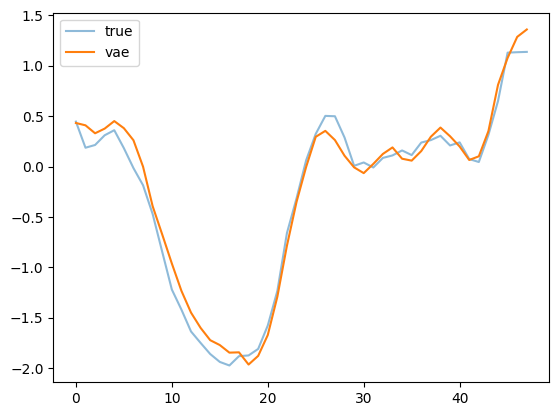

In [89]:
idx = 12
idx_feature = 0
decoded_example, actual_example = (
    xs_val_gen[idx].detach().cpu(),
    xs_val[idx].detach().cpu(),
)
sns.lineplot(actual_example[:, idx_feature].numpy(), label="true", alpha=0.5)
sns.lineplot(decoded_example[:, idx_feature].numpy(), label="vae")


# Display embedding

In [85]:
with torch.no_grad():
    xs_val = next(iter(valid_dataloader))
    emb_mean_val, emb_std_val = model.encoder(xs_val.to(device))
    emb_val = model.latent_sampler(emb_mean_val, emb_std_val)

In [86]:
emb_val.cpu().numpy().shape

(32, 20)

<Axes: xlabel='None', ylabel='None'>

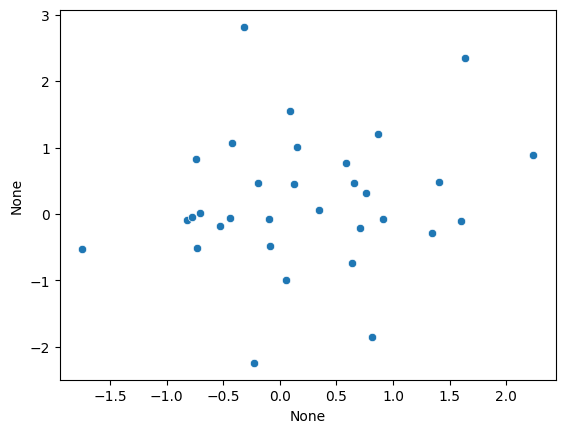

In [87]:
sns.scatterplot(x=emb_val[:, 0].cpu(), y=emb_val[:, 1].cpu())

In [88]:
# | hide
import nbdev

nbdev.nbdev_export()